---
title: "Label preferred-orientation of synaptic inputs"
format: 
    html:
        toc: true 
        code-fold: false
jupyter: python3
---

This example uses the plotting package **PyVista** for interactive rendering. Any rendering program that takes vertices and edges can work.

In [2]:
import pandas as pd
import numpy as np

from caveclient import CAVEclient
import cloudvolume 

import pyvista as pv
import matplotlib as mpl
import matplotlib.pyplot as plt

## Query the functional properties of coregistered cells

In [6]:
# Set version to the most recent major version with a flat segmentation
client = CAVEclient("minnie65_public")
client.version = 1300

# Query functional properties, keep value with highest cc_abs
functional_df = client.materialize.tables.functional_properties_v3_bcm().query(
    select_columns = {'nucleus_detection_v0': ['id', 'pt_root_id'],
                      'functional_properties_v3_bcm': ['pref_dir','pref_ori','cc_abs'],
                     },
)
print(len(functional_df))

12094


This table includes duplicates on `pt_root_id` because some cells were recorded in more than one session. For this analysis, we will keep the derived properties from the recording with the highest quality, denoted under `cc_abs`

In [14]:
# Keep the row with highest cc_abs
functional_df = (functional_df
                 .sort_values('cc_abs', ascending=False)
                 .drop_duplicates(subset='id', keep='first')
                 .reset_index(drop=True)
                )

print(len(functional_df))

10631


## Select an example functional cell

In [9]:
root_id = 864691135655627458

# query the input synapses
syn_df = client.materialize.synapse_query(post_ids=root_id)[['id','pre_pt_root_id','post_pt_root_id','ctr_pt_position']]
syn_df.head()

,id,pre_pt_root_id,post_pt_root_id,ctr_pt_position
0,174174984,864691135392563698,864691135655627458,"[186856, 191906, 22934]"
1,162422539,864691135448388082,864691135655627458,"[178626, 205198, 22722]"
2,173960580,864691135615882692,864691135655627458,"[185226, 196182, 22506]"
3,189711855,864691136911120750,864691135655627458,"[195675, 191580, 20316]"
4,142643510,864691134753572256,864691135655627458,"[170124, 106842, 19907]"


## Merge the functional properties to the synapse table

In [15]:
# Combine functional measure to synapse table (preferred orientation)

coreg_syn_ori = (syn_df.merge(functional_df[['pt_root_id', 'pref_ori']],
                              left_on='pre_pt_root_id',
                              right_on='pt_root_id', 
                              how='left')
                 .drop(columns={'pt_root_id'})
)

coreg_syn_ori = (coreg_syn_ori.merge(functional_df[['pt_root_id', 'pref_ori']],
                                     left_on='post_pt_root_id', 
                                     right_on='pt_root_id', 
                                     how='left',
                                     suffixes=['_pre','_post'])
                   .drop(columns={'pt_root_id'})
)

# Drop the synaptic partners without an orientation preference (non coregistered cells)
coreg_syn_ori = coreg_syn_ori.dropna(subset=['pref_ori_pre','pref_ori_post'])


coreg_syn_ori.tail()

,id,pre_pt_root_id,post_pt_root_id,ctr_pt_position,pref_ori_pre,pref_ori_post
8961,159745553,864691135539486066,864691135655627458,"[178414, 121410, 21070]",2.646102,2.573279
9001,158198769,864691135519025802,864691135655627458,"[175653, 124157, 20593]",0.102209,2.573279
9006,160833418,864691135293488822,864691135655627458,"[178344, 125064, 21023]",1.344499,2.573279
9043,165737524,864691135993150913,864691135655627458,"[179838, 104038, 20625]",1.417019,2.573279
9077,158328537,864691134990217850,864691135655627458,"[178680, 203290, 22572]",2.914949,2.573279


## Load the static mesh for one cell

In [16]:
# Set the static segmentaiton source to the most recent flat segmentation where that root id is valid
seg_source = 'precomputed://gs://iarpa_microns/minnie/minnie65/seg_m1300'

# load from cloudvolume
cv = cloudvolume.CloudVolume(seg_source, progress=False, use_https=True)
mesh = cv.mesh.get(root_id, lod=2)[root_id]

In [17]:
# Render the mesh vertices for pyvista
vertices = mesh.vertices
faces = mesh.faces

# add a column of all 3s to the faces
padded_faces = np.concatenate([np.full((faces.shape[0], 1), 3), faces], axis=1)

mesh_poly = pv.PolyData(vertices, faces=padded_faces)

# Flip with y axis
mesh_poly.points[:, 1] *= -1

### set the color map for orientation

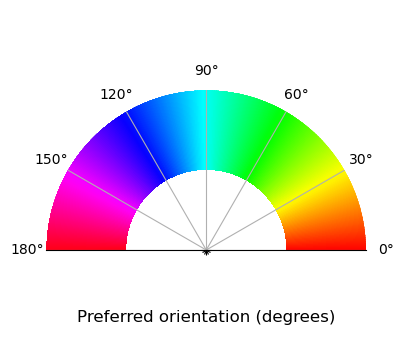

In [19]:
fig = plt.figure(figsize=[4,4])

quant_steps = 2056
colormap = plt.get_cmap('hsv', quant_steps)
norm = mpl.colors.Normalize(0.0, np.pi)

display_axes = fig.add_axes([0.1,0.1,0.8,0.8], projection='polar')
norm = mpl.colors.Normalize(0.0, np.pi)

# # Plot the colorbar onto the polar axis
cb = mpl.colorbar.ColorbarBase(display_axes, cmap=colormap,
                               norm=norm,
                               orientation='horizontal') 
# use orientation horizontal so that the gradient goes around the wheel rather than centre out

# aesthetics - get rid of border and axis labels                                   
cb.outline.set_visible(False)                                 
display_axes.set_rlim([-1,1])
display_axes.set_title('Preferred orientation (degrees)', y=0, loc='center')
plt.show() 

## Format the synapse positions

In [20]:
# format the synapse positions
presyn_positions = np.vstack(coreg_syn_ori.ctr_pt_position.to_numpy()).astype(float)
presyn_positions = presyn_positions*np.tile([4,4,40],[len(presyn_positions),1])
pre_syn_poly = pv.PolyData(presyn_positions)

# Flip with y axis
pre_syn_poly.points[:, 1] *= -1

pre_syn_colors = colormap(coreg_syn_ori.pref_ori_pre)
post_syn_color = colormap(coreg_syn_ori.pref_ori_post)[0]

## Initialize plotting object, add mesh and annotations

In [21]:
pv.set_jupyter_backend("client")
plotter = pv.Plotter(image_scale=10)

plotter.add_mesh(mesh_poly, color=post_syn_color, opacity=0.3)
plotter.add_mesh(pre_syn_poly, scalars=pre_syn_colors, rgb=True, point_size=10)

plotter.camera_position = 'zy'
plotter.set_background('#fbfbfb')

plotter.show()

Widget(value='<iframe src="http://localhost:63154/index.html?ui=P_0x213f1395d50_0&reconnect=auto" class="pyvis…

In [23]:
#| echo: false
plotter.export_html('../img/interactives/coregistered_orientation_example.html')


<center>Interactive: Preferred orientation of functionally-characterized cell inputs</center>

<iframe src="../img/interactives/coregistered_orientation_example.html" width="950px" height="600px" style="border: 2px;  "></iframe>